In [1]:
from __future__ import print_function, absolute_import, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import sklearn
import scipy

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
full = pd.concat([train, test])

In [3]:
full.info() # need to fill in Age, Cabin, Embarked, and Fare

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


First, try two benchmarks:
1. Predict that everyone dies
1. Predict that all the men die and all the women survive
Let's see what scores we get.

In [4]:
# Everone dies:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": 0})
submission.to_csv("titanic_submission_all_died.csv", index=False)
print("Accuracy on training set:", (train['Survived'] == 0).sum()/train.shape[0])
print("Accuracy on Kaggle test submission:", 0.62679) # Pretty good for just a few lines of code.
submission.head()

Accuracy on training set: 0.616161616162
Accuracy on Kaggle test submission: 0.62679


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [5]:
# All men die, all women survive:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test.Sex.apply(lambda gender: 1 if gender=='female' else 0)})
submission.to_csv("titanic_submission_women_survive.csv", index=False)
print("Accuracy on training set:", (train['Survived'] == train.Sex.apply(lambda gender: 1 if gender=='female' else 0)).sum()/train.shape[0])
print("Accuracy on Kaggle submission:", 0.76555) # It turns out this is pretty hard to beat. 
submission.head()

Accuracy on training set: 0.786756453423
Accuracy on Kaggle submission: 0.76555


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Fill in missing values

In [6]:
print("Training set:")
train.info() # tells us we have missing data in Age, Cabin, and Embarked
print("________________________________________")
print("Test set:")
test.info() # we have missing info in Age, Fare, and Cabin

Training set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
Test set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Tic

# Title: Add a "title" column (thank you others for the idea)
Also, add a "short_title" to encode fewer categories.

In [7]:
full['title'] = full.Name.str.replace('(.*, )|(\\..*)', '')
full.title.unique()
title_dict = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Don': 'Mr',
              'Rev': 'Mr', 'Dr': 'Mr', 'Mme': 'Mrs', 'Ms': 'Mrs',
              'Major': 'Mr', 'Lady': 'Mrs', 'Sir': 'Mr', 'Mlle': 'Miss', 'Col': 'Mr',
              'Capt': 'Mr', 'the Countess': 'Mrs', 'Jonkheer': 'Mr', 'Dona': 'Mrs'}
title_dict2 = {'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master', 'Don': 'Sir',
              'Rev': 'Mr', 'Dr': 'Mr', 'Mme': 'Mrs', 'Ms': 'Mrs',
              'Major': 'Mr', 'Lady': 'Lady', 'Sir': 'Sir', 'Mlle': 'Miss', 'Col': 'Mr',
              'Capt': 'Mr', 'the Countess': 'Lady', 'Jonkheer': 'Sir', 'Dona': 'Lady'}
full['short_title'] = full.title.apply(lambda title: title_dict2[title])
full[['Name', 'title', 'short_title']]
full['short_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Sir', 'Lady'], dtype=object)

# Age: Use title to fill in missing ages.

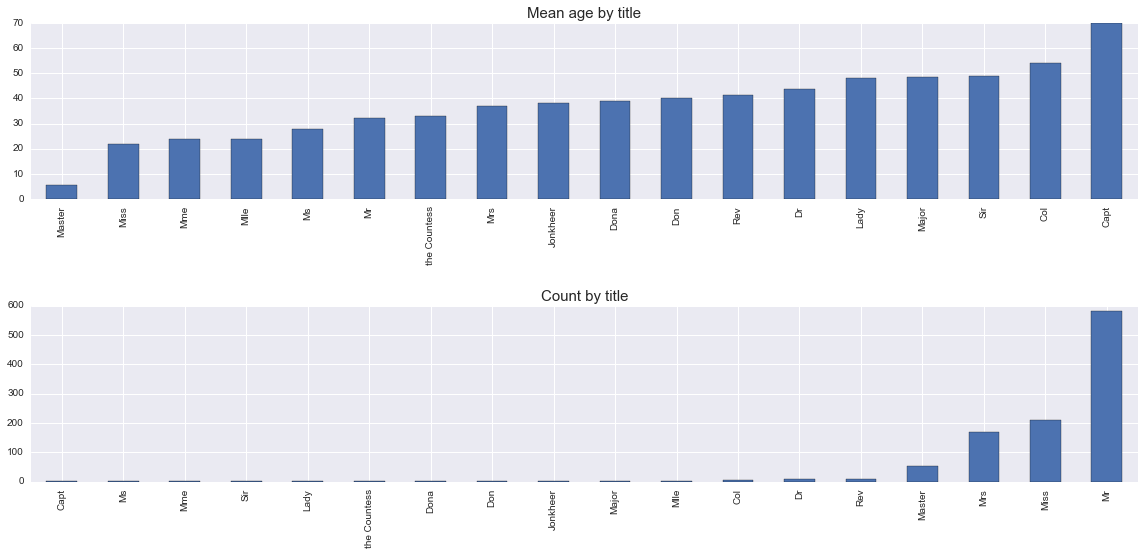

In [8]:
# Show count and mean age by title:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=False)
#secondary_x = axes[0].twinx()
full.groupby(by='title').mean()['Age'].sort_values().plot(kind='bar', ax=axes[0])
full.groupby(by='title').count()['Age'].sort_values().plot(kind='bar', ax=axes[1])
axes[0].set_title("Mean age by title", fontsize=15)
axes[1].set_title("Count by title", fontsize=15)
plt.tight_layout()
axes[0].set_xlabel('')
axes[1].set_xlabel('')

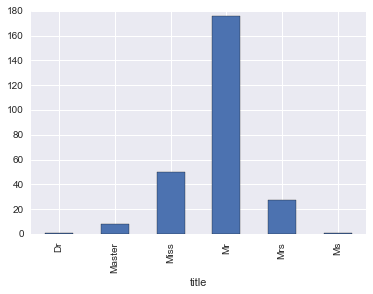

In [9]:
# By title, how many are missing ages?
# Assign the doctor the mean age of all the Doctors. Assign the young masters the mean age of the young masters. Etc.
full[pd.isnull(full.Age)].groupby(by='title').count()['Fare'].plot(kind='bar')

In [10]:
# Loop over each title with missing age values, and assign those passengers the age of the mean of the rest:
for title in full[pd.isnull(full.Age)].title.unique():
    full.loc[(full['title'] == title) & pd.isnull(full.Age), 'Age'] = full[full['title'] == title].Age.mean()

# Fare: Fill in missing fares with averages grouped by cabin class and embarkment

In [11]:
full.groupby(by=['Pclass', 'Embarked']).median()[['Fare']]

Fare
Pclass Embarked         
1      C         76.7292
       Q         90.0000
       S         52.0000
2      C         15.3146
       Q         12.3500
       S         15.3750
3      C          7.8958
       Q          7.7500
       S          8.0500

In [12]:
# Fill it in: (NB: I realized later there's only one passenger missing fare, so I didn't need to loop)
for pclass in [1, 2, 3]:
    for embarked in ['C', 'S', 'Q']:
        median_fare = full[(full.Pclass==pclass) & (full.Embarked==embarked)].Fare.median()
        full.loc[(pd.isnull(full.Fare)) & (full.Pclass==pclass) & (full.Embarked==embarked), 'Fare'] = median_fare

# Embarked: Group by Fare, Pclass, assign to mean of that group

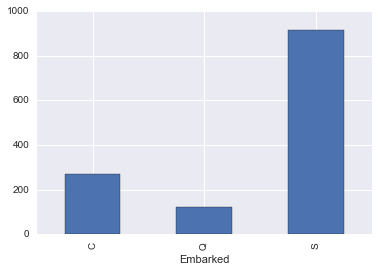

In [13]:
full.groupby(by='Embarked').count()['title'].plot(kind='bar')

In [14]:
full[pd.isnull(full.Embarked)]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title,short_title
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,Miss,Miss
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,Mrs,Mrs


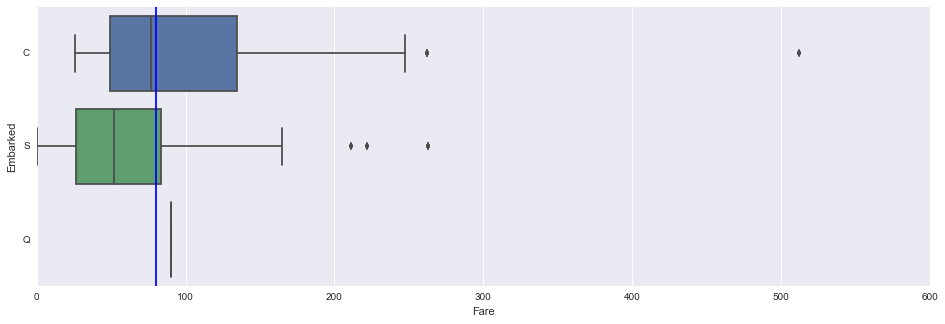

In [15]:
# A box plot of fares paid by first-class passengers from each of the three ports shows that
# $80 would be a reasonable fare for either C or Q. But Q has few passengers in total, so we'll go with 'C'
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
sns.boxplot(y='Embarked', x='Fare', data=full[full.Pclass==1], ax=ax)
ax.axvline(80)

# All missing values filled in. 

# Create categorical variables

In [16]:
"""from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
for category in 'Embarked', 'Sex', 'title':
    label_encoder.fit(full[category])
    print("'{}' variables:".format(category), list(label_encoder.classes_))
    full[category + "_categ"] = label_encoder.transform(full[category])"""

'from sklearn import preprocessing\nlabel_encoder = preprocessing.LabelEncoder()\nfor category in \'Embarked\', \'Sex\', \'title\':\n    label_encoder.fit(full[category])\n    print("\'{}\' variables:".format(category), list(label_encoder.classes_))\n    full[category + "_categ"] = label_encoder.transform(full[category])'

# Create dummy variables.
We're not going to add any more features, but we do need to convert our categorical variables to dummy variables.

In [17]:
columns = ["Pclass", "Sex", "Embarked", "title", "short_title"]
full = pd.get_dummies(data=full, columns=columns)
full.head(3)

,Age,Cabin,Fare,Name,Parch,PassengerId,SibSp,Survived,Ticket,Pclass_1,...,title_Ms,title_Rev,title_Sir,title_the Countess,short_title_Lady,short_title_Master,short_title_Miss,short_title_Mr,short_title_Mrs,short_title_Sir
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,0.0,A/5 21171,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1.0,PC 17599,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,1.0,STON/O2. 3101282,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [18]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 41 columns):
Age                   1309 non-null float64
Cabin                 295 non-null object
Fare                  1309 non-null float64
Name                  1309 non-null object
Parch                 1309 non-null int64
PassengerId           1309 non-null int64
SibSp                 1309 non-null int64
Survived              891 non-null float64
Ticket                1309 non-null object
Pclass_1              1309 non-null float64
Pclass_2              1309 non-null float64
Pclass_3              1309 non-null float64
Sex_female            1309 non-null float64
Sex_male              1309 non-null float64
Embarked_C            1309 non-null float64
Embarked_Q            1309 non-null float64
Embarked_S            1309 non-null float64
title_Capt            1309 non-null float64
title_Col             1309 non-null float64
title_Don             1309 non-null float64
title_Dona            130

# Now break out the training set and the test set again

In [19]:
full = full.drop(["Cabin"], axis=1)  # we just don't need it--too many missing values
test = full[pd.isnull(full.Survived)]
train = full[pd.notnull(full.Survived)]
test = test.drop(["Survived"], axis=1)
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 40 columns):
Age                   891 non-null float64
Fare                  891 non-null float64
Name                  891 non-null object
Parch                 891 non-null int64
PassengerId           891 non-null int64
SibSp                 891 non-null int64
Survived              891 non-null float64
Ticket                891 non-null object
Pclass_1              891 non-null float64
Pclass_2              891 non-null float64
Pclass_3              891 non-null float64
Sex_female            891 non-null float64
Sex_male              891 non-null float64
Embarked_C            891 non-null float64
Embarked_Q            891 non-null float64
Embarked_S            891 non-null float64
title_Capt            891 non-null float64
title_Col             891 non-null float64
title_Don             891 non-null float64
title_Dona            891 non-null float64
title_Dr              891 non-null float64


# Now do the logistic regression

In [34]:
"""
Leave out these baselines:
* Pclass_1
* Sex_male
* Embarked_S
* title_Mr
So a Male Mr in first class embarked at S is the baseline.

Looks like title captures enough gender information, so actually we can drop the "Sex" column altogether.
"""

cols_to_use = ['Age', 'Fare',
               'Pclass_2', 'Pclass_3',
               #'Sex_female',
               'Embarked_C', 'Embarked_Q',
               'title_Capt', 'title_Col', 'title_Don', 'title_Dona', 'title_Dr', 'title_Jonkheer',
               'title_Lady', 'title_Major', 'title_Master', 'title_Miss', 'title_Mlle', 'title_Mrs',
               'title_Ms',  'title_Rev', 'title_Sir', 'title_the Countess']

"""cols_to_use = ['Age', 'Fare',
               'Pclass_2', 'Pclass_3',
               #'Sex_female',
               'Embarked_C', 'Embarked_Q',
               'title_Master', 'title_Miss', 'title_Mrs', # These seem to be too restrictive. Try adding in royalty.
              ]

cols_to_use = ['Age', 'Fare',
               'Pclass_2', 'Pclass_3',
               #'Sex_female',
               'Embarked_C', 'Embarked_Q',
               'title_Miss', 'title_Master', 
               'title_Mrs', #'title_Mr',
               'title_Lady', 'title_Sir', 
              ]"""

X_train = train[cols_to_use]
y_train = train['Survived']
X_test = test[cols_to_use]
cols_to_use

['Age',
 'Fare',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'title_Capt',
 'title_Col',
 'title_Don',
 'title_Dona',
 'title_Dr',
 'title_Jonkheer',
 'title_Lady',
 'title_Major',
 'title_Master',
 'title_Miss',
 'title_Mlle',
 'title_Mrs',
 'title_Ms',
 'title_Rev',
 'title_Sir',
 'title_the Countess']

In [21]:
X_train = train.drop(['PassengerId', 'Name', 'Ticket', 'Survived'], axis=1) # drop string columns and 'survived'
y_train = train['Survived']
X_test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_predicted = logreg.predict(X_test)
print((logreg.predict(X_train)==y_train).sum()/len(y_train)) # what percent did it get right in training set?
logreg.score(X_train, y_train)

0.835016835017


0.83501683501683499

In [23]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_predicted.astype(int)})
submission.to_csv('titanic_submission_logreg.csv', index=False)
print(submission.shape)
submission.head()
# This scores a 0.73206. Not good enough to beat the "all women survive, all men die" model.

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Try a single decision tree

1.0


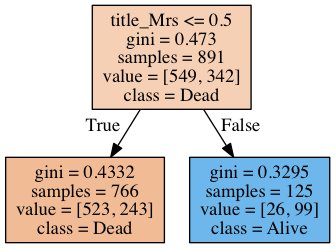

In [35]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(X_train, y_train)
y_predicted = dtc.predict(X_test)

score = dtc.score(X_test, y_predicted)
print(score)

from IPython.display import Image
from sklearn.externals.six import StringIO
import pydot
dot_data = StringIO()  
sklearn.tree.export_graphviz(dtc, out_file=dot_data, feature_names=cols_to_use,
                             class_names=['Dead', 'Alive'], filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

In [30]:
graph[0]

In [ ]:
pd.DataFrame({'feature': cols_to_use, 'importance': dtc.feature_importances_})

# Try Random Forest

In [ ]:
random_forest = RandomForestClassifier(n_estimators=10)

random_forest.fit(X_train, y_train)
y_predicted = random_forest.predict(X_test)

random_forest.score(X_train, y_train) # woah will this do well on the test set? Or is it over-fitted?

In [ ]:
submission = pd.DataFrame({
        "PassengerId": test.dropna()["PassengerId"],
        "Survived": y_predicted.astype(int)})
submission.to_csv('titanic_submission_randomforest.csv', index=False)
submission.head()
# Scores 0.78947! Heck yeah! Moved up more than 1200 spots on the leader board, into the top half!
# If I change n_estimators from 10 to 100, my training score goes to 100%
# but my actual Kaggle submission score drop to 0.77033.
# If I change n_estimators=5, I get a score of 0.6842

In [ ]:
pd.Series(random_forest.feature_importances_).plot(kind='bar')

When I ask the random_forest object to tell me what features are the most important, it says PassengerId is second most important.
This only makes sense if passengers were logged in some non-random order.
For example, the ship's manifest was assembled by first class cabin first. 
This is unlikely but let's check the correlation coeeficient make sure. 
If it's completely random we should see a value of 0.

In [ ]:
scipy.stats.pearsonr(train['PassengerId'], train['Fare'])  # r = 0.012, not correlated.
# So PassengerId is probably random and should not be included in the random forest.

In [ ]:
# Random forest:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': random_forest.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False)